# Deep Recurrent Q-Network (DRQN)

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import os
import random
import time

from gridworld import GameEnv  # The actual game environment
from dqnHelper import *        # Helper functions for training DQNs

c:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the game environment
The game environment is the same as in the previous example: the agent (blue) moves around, trying to reach any of the goal spaces (green) while avoiding the fire spaces (red). Reaching either ends the episode, but reaching a goal space results in a +1 reward, while hitting a fire space results in a -1 reward. This time, we're only going to give the agent partial knowledge of its environment (a number of spaces around its current location).

c:\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


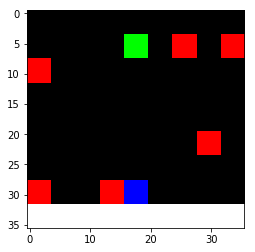

In [2]:
# Environment parameters
env_sz = 16  # Size of the game environment
n_goals = 4  # Number of goal spaces
n_fire = 16  # Number of fire spaces
img_sz = 36  # Size of the output image fed to the agent
view_sz = 4  # Vision radius

env = GameEnv(
    size = env_sz, n_goals = n_goals, n_fire = n_fire, partial = view_sz, img_sz = img_sz
)

### Implementing the network itself
This implementation is of a dueling DQN, and we'll be training it using a Double DQN setup.

In [3]:
class QNetwork:
    def __init__(self, img_sz, h_size, rnn_cell, lr = 0.0001, scope = ''):
        # The smallest image size allowed by this network is a 28x28 pixel image
        num_pixels = img_sz**2 * 3
        # Image input (as a flattened array)
        self.scalar_in = tf.placeholder(shape = [None, num_pixels], dtype = tf.float32, name = '_'.join([scope, 'scalar_in']))
        # Reshape input into a batch of 3D tensors with shape (img_sz, img_sz, 3)
        self.img_in = tf.reshape(self.scalar_in, shape = [-1, img_sz, img_sz, 3])
        
        # Convolution layers
        self.conv1 = tf.contrib.layers.convolution2d(
            inputs = self.img_in, num_outputs = 32,
            kernel_size = [8, 8], stride = [4, 4],
            padding = 'valid', biases_initializer = None,
            scope = '_'.join([scope, 'conv1'])
        )
        self.conv2 = tf.contrib.layers.convolution2d(
            inputs = self.conv1, num_outputs = 64,
            kernel_size = [4, 4], stride = [2, 2],
            padding = 'valid', biases_initializer = None,
            scope = '_'.join([scope, 'conv2'])
        )
        self.conv3 = tf.contrib.layers.convolution2d(
            inputs = self.conv2, num_outputs = 128,
            kernel_size = [2, 2], stride = [1, 1],
            padding = 'valid', biases_initializer = None,
            scope = '_'.join([scope, 'conv3'])
        )
        self.conv4 = tf.contrib.layers.convolution2d(
            inputs = self.conv3, num_outputs = h_size,
            kernel_size = self.conv3.shape[1:-1], stride = [1, 1],
            padding = 'valid', biases_initializer = None,
            scope = '_'.join([scope, 'conv4'])
        )
        self.conv_out = tf.contrib.layers.flatten(self.conv4)
        # Need to reshape the output from (batch_sz*trace_ln, h_size) to (batch_sz, trace_ln, h_size)
        self.trace_ln = tf.placeholder(dtype = tf.int32, name = '_'.join([scope, 'trace_ln']))
        self.batch_sz = tf.placeholder(dtype = tf.int32, shape = [], name = '_'.join([scope, 'batch_sz']))
        self.conv_flat = tf.reshape(self.conv_out, [self.batch_sz, self.trace_ln, h_size])
        
        # Feed the resized convolution output and the RNN hidden state into the RNN cell
        self.rnn_s_in = rnn_cell.zero_state(self.batch_sz, tf.float32)
        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(
            inputs = self.conv_flat, cell = rnn_cell, initial_state = self.rnn_s_in,
            dtype = tf.float32, scope = '_'.join([scope, 'rnn'])
        )
        # Reshape the output of the rnn back to (batch_sz*trace_ln, h_size)
        self.rnn = tf.reshape(self.rnn, shape = [-1, h_size])
        
        # Split the RNN output in half for the advantage and value streams
        self.advStream, self.valStream = tf.split(self.rnn, 2, 1)
        # Send the advantage and value vectors through separate dense layers
        self.advWts = tf.Variable(tf.random_normal([h_size//2, env.actions]))
        self.advantage = tf.matmul(self.advStream, self.advWts)
        
        self.valWts = tf.Variable(tf.random_normal([h_size//2, 1]))
        self.value = tf.matmul(self.valStream, self.valWts)
        
        # Combine the advantage and value streams into a single Q-value: Q(s, a) = V(s) + A(a)
        mean_adv = tf.reduce_mean(self.advantage, axis = 1, keepdims = True)
        self.q_out = self.value + tf.subtract(self.advantage, mean_adv)
        # Predict/suggest the next action
        self.predict = tf.argmax(self.q_out, 1)
        
        # Single out the Q-value for the predicted action
        self.actions = tf.placeholder(shape = [None], dtype = tf.int32, name = '_'.join([scope, 'actions']))
        self.actions_ohv = tf.one_hot(self.actions, env.actions, dtype = tf.float32)
        self.predict_q = tf.reduce_sum(tf.multiply(self.q_out, self.actions_ohv), axis = 1)
        
        # Compute the MSE loss between the predicted and target Q-values for the
        # target action. The target Q-values should be obtained from the target DQN
        self.targetQ = tf.placeholder(shape = [None], dtype = tf.float32, name = '_'.join([scope, 'targetQ']))
        self.td_error = tf.square(self.targetQ - self.predict_q)
        
        # In order to only propagate accurate gradients through the network, we will mask
        # the first half of the losses for each trace as per "Playing FPS Games with Deep
        # Reinforcement Learning" (Lample & Chatlot, 2016)
        self.mask_old = tf.zeros([self.batch_sz, self.trace_ln//2])
        self.mask_new = tf.ones( [self.batch_sz, self.trace_ln//2])
        self.mask = tf.reshape(tf.concat([self.mask_old, self.mask_new], 1), [-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        
        # TF ops to run parameter optimization gradients and updates
        self.trainer = tf.train.AdamOptimizer(learning_rate = lr)
        self.updateModel = self.trainer.minimize(self.loss)

### Experience replay
This class allows us to store experiences and sample them randomly to train the network. To correctly train the DRQN, we'll need to store entire episodes in the replay buffer (rather than storing steps in a single episode, clearing the buffer after each episode).

In [4]:
class experience_buffer:
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0 : len(self.buffer)-self.buffer_size+1] = []
        self.buffer.append(experience)
        
    def sample(self, batch_sz, trace_ln):
        sampled_eps = random.sample(self.buffer, batch_sz)
        sampled_traces = []
        for ep in sampled_eps:
            try:
                t_s = np.random.randint(0, len(ep)-trace_ln+1)
            except:
                print('len(self.buffer) = %d  | len(sampled_eps) = %d' % (len(self.buffer), len(sampled_eps)))
                print('len(ep) = %d  | trace_ln = %d' % (len(ep), trace_ln))
                print(self.buffer, '\n\n\n')
                print(sampled_eps)
            t_e = t_s + trace_ln
            sampled_traces.append(ep[t_s : t_e])
        sampled_traces = np.array(sampled_traces)
        return np.reshape(sampled_traces, [batch_sz*trace_ln, 5])

### Training the network
Training hyperparameters:

In [5]:
batch_sz = 4             # How many experience traces to use for each training step
trace_ln = 8             # How long each experience trace will be during training
update_freq = 5          # How often to perform a training step
gamma = 0.99             # Discount factor on the target Q-values
e_start = 1              # Starting chance of random action
e_end = 0.1              # Final chance of random action
annealing_steps = 10000  # How many steps of traiing to reduce e_start to e_end
num_episodes = 10000     # How many episodes of game environment to train network with
pre_train_steps = 10000  # How many steps of random actions to take before training begins
max_ep_ln = 50           # Max allowed length of an episode
h_size = 512             # Hidden layer size (before advantage/value split)
tau = 0.001              # Weight of main DQN's parameters to use when updating the target DQN: tau*mainDQN + (1-tau)*targetDQN
lr = 0.0001              # Learning rate
buffer_size = 1000       # Size of the experience replay buffer

log_time = 100           # Number of episodes between log outputs
ckpt_time = 1000         # Number of episodes between model checkpoints
load_model = False
save_dir = 'chkpts'

In [6]:
tf.reset_default_graph()
# Initialize the RNN cells for each network
main_rnncell   = tf.contrib.rnn.BasicLSTMCell(num_units = h_size, state_is_tuple = True)
target_rnncell = tf.contrib.rnn.BasicLSTMCell(num_units = h_size, state_is_tuple = True)
# Initialize the two dueling DQNs
mainDQN   = QNetwork(img_sz, h_size, main_rnncell,   lr, 'main')
targetDQN = QNetwork(img_sz, h_size, target_rnncell, lr, 'target')

# Initialize variables and model saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Add the TF ops to update the targetDQN parameters to the graph
trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

# Initialize the experience replay buffer
replay_buffer = experience_buffer(buffer_size = buffer_size)

# Set the rate decrease for the probability of a random action
e = e_start
step_drop = (e_start - e_end) / annealing_steps

# Create lists to contain total rewards and steps per episode
jList = []
rList = []

# Total steps counter
total_steps = 0

# Saved model checkpoints directory
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Instructions for updating:
Use the retry module or similar alternatives.


Actual training algorithm:

In [7]:
with tf.Session() as sess:
    if load_model:
        print('Loading model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    sess.run(init)
    t_start = time.time()
    
    
    # Main loop
    for i in range(num_episodes):
        ep_buffer = []
        
        # Reset the environment and get the first observation
        s = processState(env.reset(), img_sz)
        d = False
        rAll = 0
        j = 0
        
        # Reset the RNN cell's hidden state
        state = (np.zeros([1, h_size]), np.zeros([1, h_size]))
        
        # Training loop
        while j < max_ep_ln:
            j += 1
            
            # Choose an action by greedily (with e chance of a random acation) from mainDQN
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0, 4)
                # Still need to get next RNN cell state
                state1 = sess.run(mainDQN.rnn_state, feed_dict = {
                    mainDQN.scalar_in: [s],
                    mainDQN.rnn_s_in : state,
                    mainDQN.batch_sz : 1,
                    mainDQN.trace_ln : 1,
                })
            else:
                a, state1 = sess.run([mainDQN.predict, mainDQN.rnn_state], feed_dict = {
                    mainDQN.scalar_in   : [s],
                    mainDQN.rnn_s_in : state,
                    mainDQN.batch_sz : 1,
                    mainDQN.trace_ln : 1,
                })
                a = a[0]
            s1, r, d = env.step(a)
            s1 = processState(s1, img_sz)
            # Add this step to the episode's experience replay buffer
            ep_buffer.append(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))
            total_steps += 1
            if total_steps > pre_train_steps:  # Start training the DQNs
                if e > e_end:
                    e -= step_drop
                
                # If enough steps have passed, train the DQNs and update parameters
                if total_steps % update_freq == 0:
                    # Reset the RNN cell's hidden state
                    state_train = (np.zeros([batch_sz, h_size]), np.zeros([batch_sz, h_size]))
                    # Get a random sample of experiences to train with
                    train_batch = replay_buffer.sample(batch_sz, trace_ln)
                    # Run the two networks in feed-forward to get the predicted action
                    # and the target Q-values
                    a_predict = sess.run(mainDQN.predict, feed_dict = {
                        mainDQN.scalar_in: np.vstack(train_batch[:,3]),
                        mainDQN.rnn_s_in : state_train,
                        mainDQN.batch_sz : batch_sz,
                        mainDQN.trace_ln : trace_ln,
                    })
                    q_target = sess.run(targetDQN.q_out, feed_dict = {
                        targetDQN.scalar_in: np.vstack(train_batch[:,3]),
                        targetDQN.rnn_s_in : state_train,
                        targetDQN.batch_sz : batch_sz,
                        targetDQN.trace_ln : trace_ln,
                    })
                    # Zero out the Q-values for any steps that result in a finished episode
                    end_multiplier = -(train_batch[:,4] - 1)
                    # Get the Q-values of JUST the predicted actions from mainDQN
                    doubleQ = q_target[range(batch_sz*trace_ln), a_predict]
                    # Calculate the target Q-values. Note that steps with rewards (those that
                    # result in the episode ending) have a Q-value of 0, while those without
                    # a reward (steps that don't end the episode) do.
                    # targetQ = r + gamma*Q(predicted_action)
                    targetQ = train_batch[:,2] + (gamma*doubleQ * end_multiplier)
                    # Update mainDQN with our targetQ values
                    sess.run(mainDQN.updateModel, feed_dict = {
                        mainDQN.scalar_in: np.vstack(train_batch[:,0]),
                        mainDQN.targetQ  : targetQ,
                        mainDQN.actions  : train_batch[:,1],
                        mainDQN.rnn_s_in : state_train,
                        mainDQN.batch_sz : batch_sz,
                        mainDQN.trace_ln : trace_ln,
                    })
                    # Update targetDQN's parameters towards mainDQN's
                    updateTarget(targetOps, sess)
                    # End of model training step
            rAll += r
            s = s1
            state = state1
            if d:
                break
            
            # End of step
        # Add the episode to the experience replay buffer
        ep_buffer = list(zip(np.array(ep_buffer)))
        replay_buffer.add(ep_buffer)
        jList.append(j)
        rList.append(rAll)
        
        # Periodically save the model
        if i % ckpt_time == 0 and i != 0:
            saver.save(sess, os.path.join(save_dir, 'model-'+str(i)+'.ckpt'))
            print('    -- >  Saved model checkpoint  <--')
        if len(rList) % log_time == 0 and len(rList) != 0:
            t_elapsed = time.time() - t_start
            print('Ep. {:5d})  Time: {:.2f} sec\tSteps: {:6d}\tAvg. reward: {:.2f}\tP(random action) = {:.2f}'.format(
                i+1, t_elapsed, total_steps, np.mean(rList[-log_time:]), e
            ))
            t_start = time.time()
        # End of episode
    # Save trained model
    saver.save(sess, os.path.join(save_dir, 'model-'+str(i)+'ckpt'))

c:\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Ep.   100)  Time: 20.26 sec	Steps:   5000	Avg. reward: -0.98	P(random action) = 1.00
Ep.   200)  Time: 20.05 sec	Steps:  10000	Avg. reward: -1.16	P(random action) = 1.00
Ep.   300)  Time: 190.87 sec	Steps:  15000	Avg. reward: -0.86	P(random action) = 0.55
Ep.   400)  Time: 177.05 sec	Steps:  20000	Avg. reward: -0.02	P(random action) = 0.10
Ep.   500)  Time: 178.81 sec	Steps:  25000	Avg. reward: 0.32	P(random action) = 0.10
Ep.   600)  Time: 186.53 sec	Steps:  30000	Avg. reward: 0.62	P(random action) = 0.10
Ep.   700)  Time: 185.21 sec	Steps:  35000	Avg. reward: 0.92	P(random action) = 0.10
Ep.   800)  Time: 184.73 sec	Steps:  40000	Avg. reward: 1.00	P(random action) = 0.10
Ep.   900)  Time: 191.43 sec	Steps:  45000	Avg. reward: 1.36	P(random action) = 0.10
Ep.  1000)  Time: 185.96 sec	Steps:  50000	Avg. reward: 1.55	P(random action) = 0.10
    -- >  Saved model checkpoint  <--
Ep.  1100)  Time: 189.98 sec	Steps:  55000	Avg. reward: 1.79	P(random action) = 0.10
Ep.  1200)  Time: 194.58 

Ep.  9400)  Time: 196.08 sec	Steps: 470000	Avg. reward: 3.67	P(random action) = 0.10
Ep.  9500)  Time: 187.12 sec	Steps: 475000	Avg. reward: 4.12	P(random action) = 0.10
Ep.  9600)  Time: 185.65 sec	Steps: 480000	Avg. reward: 4.35	P(random action) = 0.10
Ep.  9700)  Time: 195.32 sec	Steps: 485000	Avg. reward: 3.75	P(random action) = 0.10
Ep.  9800)  Time: 187.44 sec	Steps: 490000	Avg. reward: 3.64	P(random action) = 0.10
Ep.  9900)  Time: 185.53 sec	Steps: 495000	Avg. reward: 3.52	P(random action) = 0.10
Ep. 10000)  Time: 192.86 sec	Steps: 500000	Avg. reward: 3.90	P(random action) = 0.10


### Check network learning
Mean reward over time

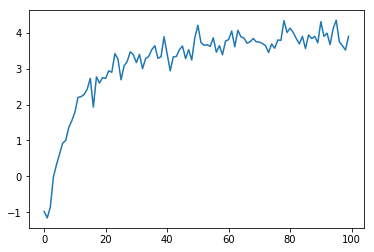

In [8]:
rMat = np.resize(np.array(rList), [len(rList)//100, 100])
rMean = np.average(rMat, 1)
plt.plot(rMean)